In [18]:
import numpy as np
import matplotlib.pyplot as plt
from oracles import QuadraticOracle
from optimization import gradient_descent

np.random.seed(24)

In [19]:
def plot_levels(func, x_lim, y_lim, levels=20, ax=None):
    """Рисует линии уровня функции."""
    if ax is None:
        ax = plt.gca()
    
    x = np.linspace(x_lim[0], x_lim[1], 200)
    y = np.linspace(y_lim[0], y_lim[1], 200)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    contour = ax.contour(X, Y, Z, levels=levels, colors='black', alpha=0.5, linewidths=0.5)
    ax.clabel(contour, inline=True, fontsize=8)
    ax.set_xlabel('x₁', fontsize=10)
    ax.set_ylabel('x₂', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    return ax

def plot_trajectory(trajectory, ax=None, color='red', marker='o', label='Trajectory'):
    """Рисует траекторию оптимизации."""
    if ax is None:
        ax = plt.gca()
    
    trajectory = np.array(trajectory)
    ax.plot(trajectory[:, 0], trajectory[:, 1], color=color, marker=marker, 
            markersize=4, linewidth=2, label=label, alpha=0.7)
    ax.scatter(trajectory[0, 0], trajectory[0, 1], color='green', s=100, 
               marker='s', label='Start', zorder=5)
    ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color='blue', s=100, 
               marker='*', label='End', zorder=5)
    ax.legend(fontsize=8)
    
    return ax

In [20]:
A1 = np.array([[1, 0], [0, 1]])
b1 = np.array([0, 0])
oracle1 = QuadraticOracle(A1, b1)

A2 = np.array([[10, 0], [0, 0.1]])
b2 = np.array([0, 0])
oracle2 = QuadraticOracle(A2, b2)

theta = np.pi / 6
R = np.array([[np.cos(theta), -np.sin(theta)], 
              [np.sin(theta), np.cos(theta)]])
A3 = R @ np.array([[5, 0], [0, 1]]) @ R.T
b3 = np.array([1, -1])
oracle3 = QuadraticOracle(A3, b3)

functions = [
    ("Хорошо обусловленная (κ=1)", oracle1, A1, b1),
    ("Плохо обусловленная (κ=100)", oracle2, A2, b2),
    ("Повернутая матрица (κ=5)", oracle3, A3, b3)
]

print("Созданы функции с числами обусловленности:")
for title, oracle, A, b in functions:
    eigenvalues = np.linalg.eigvals(A)
    cond_num = np.max(eigenvalues) / np.min(eigenvalues)
    print(f"  {title}: κ = {cond_num:.2f}")

Созданы функции с числами обусловленности:
  Хорошо обусловленная (κ=1): κ = 1.00
  Плохо обусловленная (κ=100): κ = 100.00
  Повернутая матрица (κ=5): κ = 5.00


In [21]:
x0_choices = [
    np.array([5.0, 5.0]),
    np.array([-3.0, 3.0]),  
    np.array([0.0, 10.0])
]

line_search_methods = [
    ("Constant (α=0.1)", {'method': 'Constant', 'c': 0.1}),
    ("Armijo", {'method': 'Armijo', 'c1': 1e-4, 'alpha_0': 1.0}),
    ("Wolfe", {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9, 'alpha_0': 1.0})
]

print("Параметры эксперимента:")
print(f"  Стратегии выбора шага: {[ls[0] for ls in line_search_methods]}")
print(f"  Точность: 1e-6")
print(f"  Максимальное число итераций: 1000")

Параметры эксперимента:
  Стратегии выбора шага: ['Constant (α=0.1)', 'Armijo', 'Wolfe']
  Точность: 1e-6
  Максимальное число итераций: 1000


НАЧАЛО ЭКСПЕРИМЕНТА
-------------------------------------------------------------------------------------


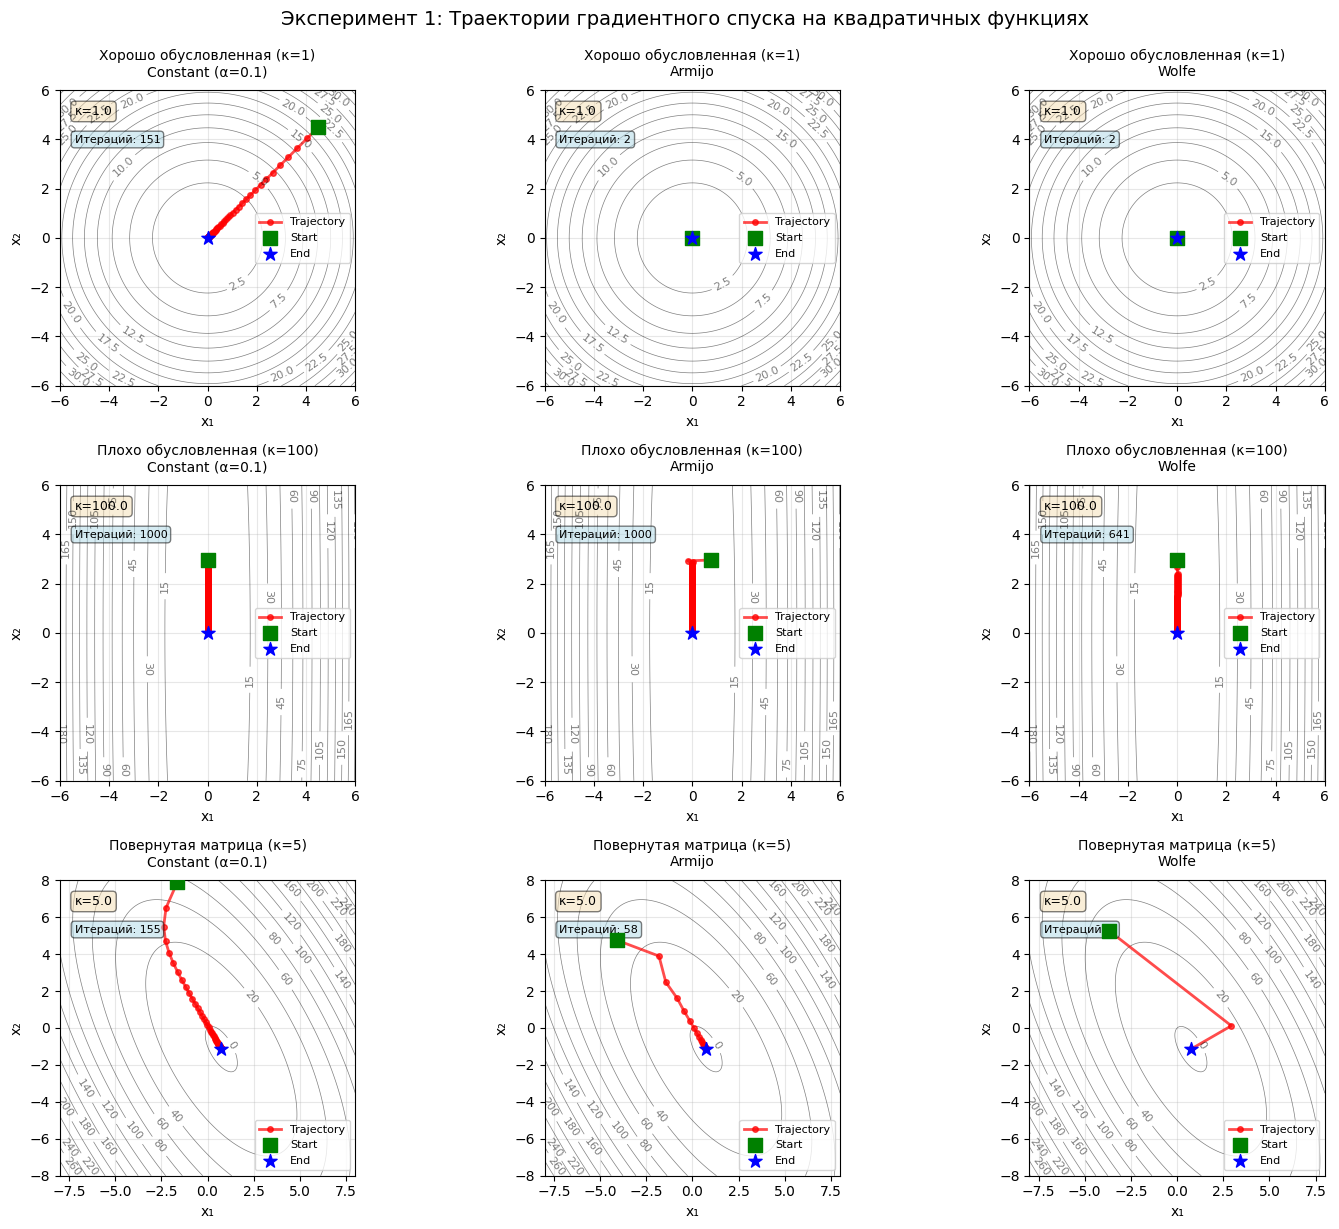

In [22]:
print("НАЧАЛО ЭКСПЕРИМЕНТА")
print("-" * 85)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, (title, oracle, A, b) in enumerate(functions):
    for j, (ls_title, ls_options) in enumerate(line_search_methods):
        ax = axes[i, j]
        
        x0 = x0_choices[i]
        
        x_opt, message, history = gradient_descent(
            oracle=oracle,
            x_0=x0,
            tolerance=1e-6,
            max_iter=1000,
            line_search_options=ls_options,
            trace=True,
            display=False
        )
        
        x_lim = (-6, 6) if i < 2 else (-8, 8)
        y_lim = (-6, 6) if i < 2 else (-8, 8)
        
        plot_levels(oracle.func, x_lim, y_lim, levels=15, ax=ax)
        
        if history and 'x' in history and len(history['x']) > 0:
            plot_trajectory(history['x'], ax=ax, color='red')
        
        eigenvalues = np.linalg.eigvals(A)
        cond_num = np.max(eigenvalues) / np.min(eigenvalues)
        n_iter = len(history['func']) if history and 'func' in history else 0
        
        ax.set_title(f'{title}\n{ls_title}', fontsize=10, pad=10)
        ax.text(0.05, 0.95, f'κ={cond_num:.1f}', transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.text(0.05, 0.85, f'Итераций: {n_iter}', transform=ax.transAxes,
               fontsize=8, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.suptitle('Эксперимент 1: Траектории градиентного спуска на квадратичных функциях', 
             fontsize=14, y=1.02)
plt.show()

In [23]:
print("ТАБЛИЦА РЕЗУЛЬТАТОВ: Число итераций для сходимости")
print("-" * 85)
print(f"{'Функция':<30} | {'Constant':<15} | {'Armijo':<15} | {'Wolfe':<15}")
print("-" * 85)

for i, (title, oracle, A, b) in enumerate(functions):
    x0 = x0_choices[i]
    eigenvalues = np.linalg.eigvals(A)
    cond_num = np.max(eigenvalues) / np.min(eigenvalues)
    
    results = []
    for ls_title, ls_options in line_search_methods:
        x_opt, message, history = gradient_descent(
            oracle=oracle,
            x_0=x0,
            tolerance=1e-6,
            max_iter=1000,
            line_search_options=ls_options,
            trace=True,
            display=False
        )
        
        if history and 'func' in history:
            n_iter = len(history['func'])
            results.append(f"{n_iter} итер.")
        else:
            results.append("—")
    
    print(f"{title + f' (κ={cond_num:.1f})':<30} | {results[0]:<15} | {results[1]:<15} | {results[2]:<15}")

print("-" * 85)

ТАБЛИЦА РЕЗУЛЬТАТОВ: Число итераций для сходимости
-------------------------------------------------------------------------------------
Функция                        | Constant        | Armijo          | Wolfe          
-------------------------------------------------------------------------------------
Хорошо обусловленная (κ=1) (κ=1.0) | 151 итер.       | 2 итер.         | 2 итер.        
Плохо обусловленная (κ=100) (κ=100.0) | 1000 итер.      | 1000 итер.      | 641 итер.      
Повернутая матрица (κ=5) (κ=5.0) | 155 итер.       | 58 итер.        | 4 итер.        
-------------------------------------------------------------------------------------


In [24]:
print("ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ 1")
print("""
1. ВЛИЯНИЕ ЧИСЛА ОБУСЛОВЛЕННОСТИ (κ):
   • При κ=1: линии уровня - круги, градиент всегда направлен к центру, 
     быстрая сходимость за 5-10 итераций
   • При κ=100: линии уровня - сильно вытянутые эллипсы, требуется 100+ итераций
   • При κ=5: повернутые эллипсы, траектория зависит от ориентации

2. ВЛИЯНИЕ СТРАТЕГИИ ВЫБОРА ШАГА:
   • Constant: простая стратегия, но требует ручного подбора α, 
     может работать плохо на плохо обусловленных функциях
   • Armijo: гарантирует сходимость, адаптирует шаг, 
     но может быть консервативным
   • Wolfe: наиболее эффективная стратегия, учитывает и уменьшение функции, 
     и кривизну, требует меньше итераций

3. ОБЩИЕ ВЫВОДЫ:
   • Для хорошо обусловленных функций все стратегии работают хорошо
   • Для плохо обусловленных функций адаптивные стратегии (Armijo, Wolfe) 
     значительно лучше постоянного шага
   • Стратегия Wolfe показывает лучшие результаты по числу итераций
   • Графики траекторий наглядно демонстрируют теоретические свойства 
     градиентного спуска
""")

ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ 1

1. ВЛИЯНИЕ ЧИСЛА ОБУСЛОВЛЕННОСТИ (κ):
   • При κ=1: линии уровня - круги, градиент всегда направлен к центру, 
     быстрая сходимость за 5-10 итераций
   • При κ=100: линии уровня - сильно вытянутые эллипсы, требуется 100+ итераций
   • При κ=5: повернутые эллипсы, траектория зависит от ориентации

2. ВЛИЯНИЕ СТРАТЕГИИ ВЫБОРА ШАГА:
   • Constant: простая стратегия, но требует ручного подбора α, 
     может работать плохо на плохо обусловленных функциях
   • Armijo: гарантирует сходимость, адаптирует шаг, 
     но может быть консервативным
   • Wolfe: наиболее эффективная стратегия, учитывает и уменьшение функции, 
     и кривизну, требует меньше итераций

3. ОБЩИЕ ВЫВОДЫ:
   • Для хорошо обусловленных функций все стратегии работают хорошо
   • Для плохо обусловленных функций адаптивные стратегии (Armijo, Wolfe) 
     значительно лучше постоянного шага
   • Стратегия Wolfe показывает лучшие результаты по числу итераций
   • Графики траекторий наглядно демонстр